In [1]:
!pip install tensorflow==2.17.0 opencv-python matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Making the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
# Incompress the labelled faces in the wild dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW images from the exisitng repository to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [5]:
# Import uuid
import uuid

In [8]:
import time

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print("Failed to grab frame")
        break
        
    # Cut down to 250x250
    frame = frame[120:120+250, 200:200+250, :]

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Wait for the key press
    key = cv2.waitKey(1) & 0XFF
    
    # Capturing anchors
    if key == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
            

    # Capturing positives
    if key == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
           

    # Breaking gracefully when 'q' is pressed
    if key == ord('q'):
        break

# Release the webcam
cap.release()

# Close the image show frame
cv2.destroyAllWindows()

In [11]:
# Load an image from a file
img = cv2.imread('data/anchor/00b5eae7-92ac-11ef-8d26-f209a11ea55b.jpg')
# Display the image in a window
cv2.imshow('Image', img)

# Wait indefinitely until a key is pressed
cv2.waitKey(0)

# Close the window
cv2.destroyAllWindows()

In [6]:
# Get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
dir_test.next()

b'data\\anchor\\475a55e0-92ac-11ef-bbcb-f209a11ea55b.jpg'

In [9]:
# Image preprocessing function - Scale and Resize
def preprocess(file_path):

  # Read in image from file path
  byte_img = tf.io.read_file(file_path)
  # Load in the image
  img = tf.io.decode_jpeg(byte_img)
  # Preprocessing the image - resizing the image to be 100x100x3
  img = tf.image.resize(img, (100, 100))
  # Scale image to be between 0 and 1
  img = img / 255.0
  # Return image
  return img

In [10]:
img = preprocess('data\\anchor\\4433752d-92ac-11ef-8043-f209a11ea55b.jpg')

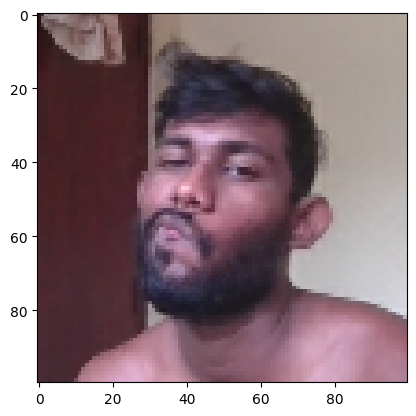

In [11]:
plt.imshow(img)

In [12]:
img.numpy().max()

1.0

In [13]:
img.numpy().min()

0.071078435

In [26]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [14]:
# Creating labelled dataset

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
samp[1]

NameError: name 'samp' is not defined

In [16]:
# Preprocess the dataset
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [17]:
# Dataloader pipelien

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [18]:
samples = data.as_numpy_iterator()
len(samples.next())

3

In [19]:
samples = data.as_numpy_iterator()

In [20]:
samp = samples.next()

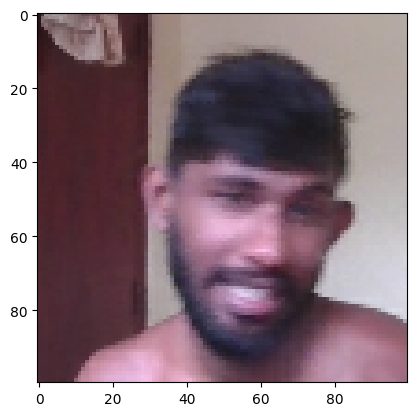

In [21]:
plt.imshow(samp[1])

In [22]:
# Training partition

train_data = data.take(round(len(data)*.7))

# Passing the data as batch of 16 images
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [24]:
# Tesing partition
test_data = data.skip(round(len(data)*.7)) # Skipping train 70% data
test_data = test_data.take(round(len(data)*.3)) # Grabbing the last 30% data as test partition
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [25]:
# Embedding layer

def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image') # Input Layer

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp) # Convolution Layer
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) # Max pooling layer

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding' )

In [26]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Siamese L1 Distance layer
class L1Dist(Layer):

  # Init method - inheritance  
  def __init__(self, **kwargs):
    super().__init__()

  # Similarity calculation
  def call(self, input_embedding, validation_embedding):
    # Converting to tensors (1, None, 4096)  
    input_embedding = tf.convert_to_tensor(input_embedding)
    validation_embedding = tf.convert_to_tensor(validation_embedding)
    
    l1_distance =  tf.math.abs(input_embedding - validation_embedding)
    # Removing a dimension - output shape: (None, 4096)   
    l1_distance = tf.squeeze(l1_distance, axis=0)   
    return l1_distance  

In [100]:
def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Generate embeddings
    embedding_input = embedding(input_image)
    embedding_validation = embedding(validation_image)
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding_input, embedding_validation)
    
    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [101]:
siamese_model = make_siamese_model()

In [110]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_10 (L1Dist)           │ (None, 4096)              │               0 │ embedding[20][0],          │
│                               │                           │                 │ embedding[21][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_10[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)